## 0. 텐서플로우 메모리 관리 코드

In [1]:
# 워닝 무시
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

2022-08-01 01:28:01.373481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 01:28:01.402347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 01:28:01.405319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## 1. 패키지 로드

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import layers, regularizers
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, distance
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, recall_score)
from tqdm.notebook import tqdm 

## 2. 데이터 로드

In [4]:
train_df = pd.read_csv('./data/train.csv') # 학습용 데이터
test_df = pd.read_csv('./data/test.csv') # 테스트용 데이터
val_df = pd.read_csv('./data/val.csv') # 검증용 데이터

## 3. EDA를 통한 피처 선정

In [171]:
select_feature = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V30']
select_feature_val = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V30', 'Class']

## 4. 데이터 전처리

In [172]:
train_X = train_df[select_feature].values
test_X = test_df[select_feature].values
val_X = val_df[select_feature]
val_Y = val_df['Class']

In [23]:
train_X = train_df[train_df.columns[1:]].values # id를 제외하여 train_X 생성
test_X = test_df[test_df.columns[1:]].values # id를 제외하여 test_X 생성
val_X = val_df[val_df.columns[1:-1]].values # id와 Class를 제외하여 val_X 생성
val_Y = val_df['Class'] # Class 값으로 val_Y 생성

In [173]:
input_dim = train_X.shape[1] # 입력층의 dim 설정

## 5. AutoEncoder 모델 생성

In [174]:
# 모델 Layer 쌓기 
input_layer = layers.Input(shape=(input_dim,))
encoder = Dense(12, activation='relu',
               activity_regularizer=regularizers.l1(10e-5))(input_layer)
batch_normal = BatchNormalization()(encoder)
encoder = Dense(8, activation='relu')(batch_normal)
batch_normal = BatchNormalization()(encoder)
encoder = Dense(4, activation='relu')(batch_normal)
batch_normal = BatchNormalization()(encoder)
decoder = Dense(4, activation='relu')(batch_normal)
batch_normal = BatchNormalization()(decoder)
decoder = Dense(8, activation='relu')(batch_normal)
batch_normal = BatchNormalization()(decoder)
decoder = Dense(12, activation='relu')(batch_normal)
decoder = Dense(input_dim, activation='linear')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [175]:
# 모델 Params 설정
EPOCHS = 2000
batch_size = 8192 * 2

In [176]:
# 모델 callback 함수 설정
checkpointer = ModelCheckpoint(filepath='./model/keras_best.h5', verbos=1, save_best_only=True, monitor='val_accuracy', mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=200)

In [177]:
# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

## 6. 모델 학습

In [178]:
# 모델 학습
history = autoencoder.fit(train_X, train_X, epochs=EPOCHS, batch_size=batch_size, shuffle=True, verbose=1, 
                          callbacks=[checkpointer, earlystopping], validation_split=0.2, workers=4)

Epoch 1/2000
6/6 [==============================] - 1s 50ms/step - loss: 1.6230 - accuracy: 0.1131 - val_loss: 1.4773 - val_accuracy: 0.0560
Epoch 2/2000
6/6 [==============================] - 0s 23ms/step - loss: 1.5760 - accuracy: 0.1179 - val_loss: 1.4593 - val_accuracy: 0.0600
Epoch 3/2000
6/6 [==============================] - 0s 28ms/step - loss: 1.5371 - accuracy: 0.1282 - val_loss: 1.4434 - val_accuracy: 0.0708
Epoch 4/2000
6/6 [==============================] - 0s 26ms/step - loss: 1.5052 - accuracy: 0.1375 - val_loss: 1.4296 - val_accuracy: 0.0935
Epoch 5/2000
6/6 [==============================] - 0s 25ms/step - loss: 1.4793 - accuracy: 0.1487 - val_loss: 1.4170 - val_accuracy: 0.1268
Epoch 6/2000
6/6 [==============================] - 0s 24ms/step - loss: 1.4574 - accuracy: 0.1591 - val_loss: 1.4050 - val_accuracy: 0.1634
Epoch 7/2000
6/6 [==============================] - 0s 24ms/step - loss: 1.4389 - accuracy: 0.1691 - val_loss: 1.3930 - val_accuracy: 0.2011
Epoch 8/2000


Epoch 59/2000
6/6 [==============================] - 0s 14ms/step - loss: 1.0588 - accuracy: 0.4551 - val_loss: 0.9781 - val_accuracy: 0.5750
Epoch 60/2000
6/6 [==============================] - 0s 17ms/step - loss: 1.0544 - accuracy: 0.4570 - val_loss: 0.9745 - val_accuracy: 0.5754
Epoch 61/2000
6/6 [==============================] - 0s 19ms/step - loss: 1.0501 - accuracy: 0.4591 - val_loss: 0.9708 - val_accuracy: 0.5757
Epoch 62/2000
6/6 [==============================] - 0s 20ms/step - loss: 1.0460 - accuracy: 0.4607 - val_loss: 0.9673 - val_accuracy: 0.5760
Epoch 63/2000
6/6 [==============================] - 0s 16ms/step - loss: 1.0421 - accuracy: 0.4624 - val_loss: 0.9639 - val_accuracy: 0.5765
Epoch 64/2000
6/6 [==============================] - 0s 9ms/step - loss: 1.0377 - accuracy: 0.4639 - val_loss: 0.9604 - val_accuracy: 0.5765
Epoch 65/2000
6/6 [==============================] - 0s 14ms/step - loss: 1.0340 - accuracy: 0.4665 - val_loss: 0.9573 - val_accuracy: 0.5769
Epoch 6

Epoch 117/2000
6/6 [==============================] - 0s 10ms/step - loss: 0.8742 - accuracy: 0.4233 - val_loss: 0.8427 - val_accuracy: 0.5544
Epoch 118/2000
6/6 [==============================] - 0s 9ms/step - loss: 0.8724 - accuracy: 0.4231 - val_loss: 0.8410 - val_accuracy: 0.5559
Epoch 119/2000
6/6 [==============================] - 0s 9ms/step - loss: 0.8705 - accuracy: 0.4230 - val_loss: 0.8401 - val_accuracy: 0.5557
Epoch 120/2000
6/6 [==============================] - 0s 9ms/step - loss: 0.8686 - accuracy: 0.4224 - val_loss: 0.8394 - val_accuracy: 0.5590
Epoch 121/2000
6/6 [==============================] - 0s 9ms/step - loss: 0.8683 - accuracy: 0.4237 - val_loss: 0.8378 - val_accuracy: 0.5583
Epoch 122/2000
6/6 [==============================] - 0s 10ms/step - loss: 0.8658 - accuracy: 0.4246 - val_loss: 0.8355 - val_accuracy: 0.5605
Epoch 123/2000
6/6 [==============================] - 0s 9ms/step - loss: 0.8645 - accuracy: 0.4241 - val_loss: 0.8353 - val_accuracy: 0.5576
Epoc

6/6 [==============================] - 0s 23ms/step - loss: 0.8299 - accuracy: 0.4473 - val_loss: 0.8020 - val_accuracy: 0.5890
Epoch 175/2000
6/6 [==============================] - 0s 24ms/step - loss: 0.8290 - accuracy: 0.4487 - val_loss: 0.8008 - val_accuracy: 0.5891
Epoch 176/2000
6/6 [==============================] - 0s 29ms/step - loss: 0.8286 - accuracy: 0.4482 - val_loss: 0.8003 - val_accuracy: 0.5893
Epoch 177/2000
6/6 [==============================] - 0s 23ms/step - loss: 0.8284 - accuracy: 0.4499 - val_loss: 0.8007 - val_accuracy: 0.5913
Epoch 178/2000
6/6 [==============================] - 0s 21ms/step - loss: 0.8281 - accuracy: 0.4516 - val_loss: 0.8004 - val_accuracy: 0.5897
Epoch 179/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8291 - accuracy: 0.4495 - val_loss: 0.7995 - val_accuracy: 0.5901
Epoch 180/2000
6/6 [==============================] - 0s 18ms/step - loss: 0.8286 - accuracy: 0.4514 - val_loss: 0.7979 - val_accuracy: 0.5905
Epoch 181/2000

6/6 [==============================] - 0s 21ms/step - loss: 0.8177 - accuracy: 0.4765 - val_loss: 0.7845 - val_accuracy: 0.6013
Epoch 232/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8175 - accuracy: 0.4763 - val_loss: 0.7841 - val_accuracy: 0.6018
Epoch 233/2000
6/6 [==============================] - 0s 21ms/step - loss: 0.8178 - accuracy: 0.4773 - val_loss: 0.7836 - val_accuracy: 0.6023
Epoch 234/2000
6/6 [==============================] - 0s 26ms/step - loss: 0.8166 - accuracy: 0.4785 - val_loss: 0.7837 - val_accuracy: 0.6029
Epoch 235/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8162 - accuracy: 0.4788 - val_loss: 0.7842 - val_accuracy: 0.6025
Epoch 236/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8167 - accuracy: 0.4787 - val_loss: 0.7832 - val_accuracy: 0.6019
Epoch 237/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8168 - accuracy: 0.4789 - val_loss: 0.7833 - val_accuracy: 0.6028
Epoch 238/2000

6/6 [==============================] - 0s 19ms/step - loss: 0.8120 - accuracy: 0.4972 - val_loss: 0.7750 - val_accuracy: 0.6116
Epoch 289/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8126 - accuracy: 0.4980 - val_loss: 0.7747 - val_accuracy: 0.6110
Epoch 290/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8129 - accuracy: 0.4975 - val_loss: 0.7744 - val_accuracy: 0.6125
Epoch 291/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8128 - accuracy: 0.4988 - val_loss: 0.7744 - val_accuracy: 0.6121
Epoch 292/2000
6/6 [==============================] - 0s 22ms/step - loss: 0.8130 - accuracy: 0.4975 - val_loss: 0.7744 - val_accuracy: 0.6114
Epoch 293/2000
6/6 [==============================] - 0s 23ms/step - loss: 0.8125 - accuracy: 0.4988 - val_loss: 0.7737 - val_accuracy: 0.6137
Epoch 294/2000
6/6 [==============================] - 0s 12ms/step - loss: 0.8122 - accuracy: 0.4999 - val_loss: 0.7746 - val_accuracy: 0.6131
Epoch 295/2000

6/6 [==============================] - 0s 19ms/step - loss: 0.8097 - accuracy: 0.5127 - val_loss: 0.7696 - val_accuracy: 0.6173
Epoch 346/2000
6/6 [==============================] - 0s 18ms/step - loss: 0.8097 - accuracy: 0.5137 - val_loss: 0.7693 - val_accuracy: 0.6217
Epoch 347/2000
6/6 [==============================] - 0s 21ms/step - loss: 0.8096 - accuracy: 0.5150 - val_loss: 0.7696 - val_accuracy: 0.6190
Epoch 348/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8103 - accuracy: 0.5133 - val_loss: 0.7695 - val_accuracy: 0.6177
Epoch 349/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8107 - accuracy: 0.5127 - val_loss: 0.7691 - val_accuracy: 0.6197
Epoch 350/2000
6/6 [==============================] - 0s 24ms/step - loss: 0.8097 - accuracy: 0.5157 - val_loss: 0.7691 - val_accuracy: 0.6219
Epoch 351/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8104 - accuracy: 0.5161 - val_loss: 0.7689 - val_accuracy: 0.6212
Epoch 352/2000

6/6 [==============================] - 0s 21ms/step - loss: 0.8096 - accuracy: 0.5236 - val_loss: 0.7665 - val_accuracy: 0.6235
Epoch 403/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8088 - accuracy: 0.5249 - val_loss: 0.7666 - val_accuracy: 0.6248
Epoch 404/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8083 - accuracy: 0.5257 - val_loss: 0.7666 - val_accuracy: 0.6248
Epoch 405/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8080 - accuracy: 0.5244 - val_loss: 0.7665 - val_accuracy: 0.6226
Epoch 406/2000
6/6 [==============================] - 0s 18ms/step - loss: 0.8083 - accuracy: 0.5243 - val_loss: 0.7671 - val_accuracy: 0.6249
Epoch 407/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8084 - accuracy: 0.5247 - val_loss: 0.7662 - val_accuracy: 0.6244
Epoch 408/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8083 - accuracy: 0.5253 - val_loss: 0.7662 - val_accuracy: 0.6251
Epoch 409/2000

6/6 [==============================] - 0s 22ms/step - loss: 0.8078 - accuracy: 0.5319 - val_loss: 0.7646 - val_accuracy: 0.6291
Epoch 460/2000
6/6 [==============================] - 0s 18ms/step - loss: 0.8077 - accuracy: 0.5336 - val_loss: 0.7649 - val_accuracy: 0.6281
Epoch 461/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8072 - accuracy: 0.5335 - val_loss: 0.7647 - val_accuracy: 0.6278
Epoch 462/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8084 - accuracy: 0.5331 - val_loss: 0.7640 - val_accuracy: 0.6286
Epoch 463/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8075 - accuracy: 0.5332 - val_loss: 0.7646 - val_accuracy: 0.6277
Epoch 464/2000
6/6 [==============================] - 0s 21ms/step - loss: 0.8077 - accuracy: 0.5320 - val_loss: 0.7646 - val_accuracy: 0.6274
Epoch 465/2000
6/6 [==============================] - 0s 21ms/step - loss: 0.8076 - accuracy: 0.5321 - val_loss: 0.7642 - val_accuracy: 0.6288
Epoch 466/2000

6/6 [==============================] - 0s 20ms/step - loss: 0.8065 - accuracy: 0.5394 - val_loss: 0.7628 - val_accuracy: 0.6291
Epoch 517/2000
6/6 [==============================] - 0s 21ms/step - loss: 0.8071 - accuracy: 0.5372 - val_loss: 0.7624 - val_accuracy: 0.6280
Epoch 518/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8067 - accuracy: 0.5389 - val_loss: 0.7642 - val_accuracy: 0.6282
Epoch 519/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8084 - accuracy: 0.5391 - val_loss: 0.7618 - val_accuracy: 0.6278
Epoch 520/2000
6/6 [==============================] - 0s 18ms/step - loss: 0.8069 - accuracy: 0.5375 - val_loss: 0.7641 - val_accuracy: 0.6280
Epoch 521/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8063 - accuracy: 0.5394 - val_loss: 0.7619 - val_accuracy: 0.6293
Epoch 522/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8069 - accuracy: 0.5398 - val_loss: 0.7636 - val_accuracy: 0.6300
Epoch 523/2000

6/6 [==============================] - 0s 20ms/step - loss: 0.8061 - accuracy: 0.5420 - val_loss: 0.7614 - val_accuracy: 0.6275
Epoch 574/2000
6/6 [==============================] - 0s 22ms/step - loss: 0.8056 - accuracy: 0.5429 - val_loss: 0.7619 - val_accuracy: 0.6273
Epoch 575/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8055 - accuracy: 0.5432 - val_loss: 0.7619 - val_accuracy: 0.6261
Epoch 576/2000
6/6 [==============================] - 0s 21ms/step - loss: 0.8057 - accuracy: 0.5418 - val_loss: 0.7614 - val_accuracy: 0.6261
Epoch 577/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8063 - accuracy: 0.5417 - val_loss: 0.7613 - val_accuracy: 0.6276
Epoch 578/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8053 - accuracy: 0.5436 - val_loss: 0.7624 - val_accuracy: 0.6265
Epoch 579/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8057 - accuracy: 0.5428 - val_loss: 0.7609 - val_accuracy: 0.6270
Epoch 580/2000

6/6 [==============================] - 0s 20ms/step - loss: 0.8061 - accuracy: 0.5446 - val_loss: 0.7609 - val_accuracy: 0.6257
Epoch 631/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8051 - accuracy: 0.5454 - val_loss: 0.7603 - val_accuracy: 0.6257
Epoch 632/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8051 - accuracy: 0.5449 - val_loss: 0.7608 - val_accuracy: 0.6262
Epoch 633/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8054 - accuracy: 0.5447 - val_loss: 0.7605 - val_accuracy: 0.6259
Epoch 634/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8061 - accuracy: 0.5454 - val_loss: 0.7602 - val_accuracy: 0.6271
Epoch 635/2000
6/6 [==============================] - 0s 19ms/step - loss: 0.8052 - accuracy: 0.5457 - val_loss: 0.7603 - val_accuracy: 0.6265
Epoch 636/2000
6/6 [==============================] - 0s 22ms/step - loss: 0.8048 - accuracy: 0.5456 - val_loss: 0.7605 - val_accuracy: 0.6263
Epoch 637/2000

6/6 [==============================] - 0s 19ms/step - loss: 0.8048 - accuracy: 0.5464 - val_loss: 0.7596 - val_accuracy: 0.6247
Epoch 688/2000
6/6 [==============================] - 0s 22ms/step - loss: 0.8045 - accuracy: 0.5465 - val_loss: 0.7594 - val_accuracy: 0.6248
Epoch 689/2000
6/6 [==============================] - 0s 21ms/step - loss: 0.8049 - accuracy: 0.5466 - val_loss: 0.7601 - val_accuracy: 0.6257
Epoch 690/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8046 - accuracy: 0.5468 - val_loss: 0.7598 - val_accuracy: 0.6246
Epoch 691/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8049 - accuracy: 0.5461 - val_loss: 0.7598 - val_accuracy: 0.6245
Epoch 692/2000
6/6 [==============================] - 0s 21ms/step - loss: 0.8047 - accuracy: 0.5464 - val_loss: 0.7595 - val_accuracy: 0.6247
Epoch 693/2000
6/6 [==============================] - 0s 20ms/step - loss: 0.8050 - accuracy: 0.5471 - val_loss: 0.7599 - val_accuracy: 0.6250
Epoch 694/2000

## 7. 오류 분포 확인

In [179]:
pred_val = autoencoder.predict(val_X)
mse = np.mean(np.power(val_X - pred_val, 2), axis=1)

In [180]:
error_df = pd.DataFrame({'reconstruction_error' : mse, 'true_class' : val_Y})
error_df.describe()

,reconstruction_error,true_class
count,28462.000000,28462.000000
mean,0.784269,0.001054
std,2.478186,0.032449
min,0.030074,0.000000
25%,0.299744,0.000000
50%,0.507025,0.000000
75%,0.836842,0.000000
max,146.137464,1.000000


### 1) 정상 데이터의 재구성 오류 분포 확인

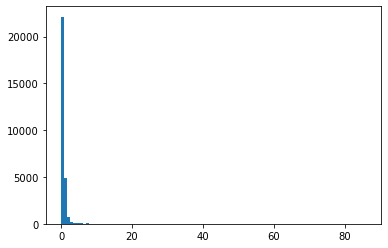

In [181]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class'] == 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=100)

### 2) 이상 데이터의 재구성 오류 확인

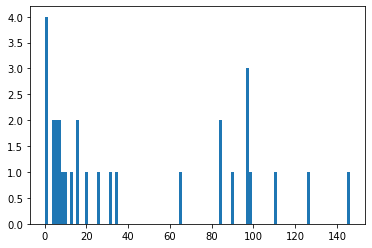

In [182]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=100)

### 3) 정밀도 vs 재현율

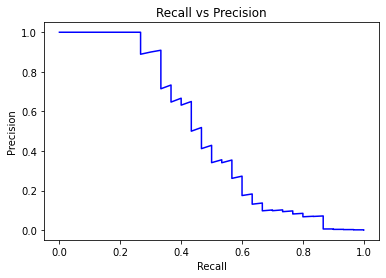

In [183]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### 4) 임계값에 따른 정밀도

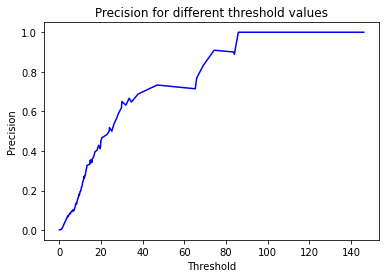

In [184]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

### 5) 임계값에 따른 재현율

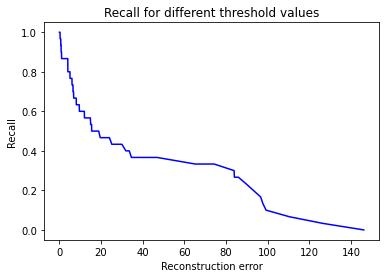

In [185]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

## 8. 학습 데이터에서 이상치 판명 데이터 제거
- recall_score를 기준

In [167]:
# racall score가 1인 최대 임계값 구하기
recall_score_list = []
max_th = 0

for i in tqdm(th):
    pred_class = np.where(mse > i, 1, 0)
    score = recall_score(val_Y, pred_class)
    if (score == 1) & (max_th < i):
        max_th = i

  0%|          | 0/28451 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [91]:
# 구한 임계값으로 train 예측
pred_X = autoencoder.predict(train_X)
mse = np.mean(np.power(train_X - pred_X, 2), axis=1)
train_pred_class = np.where(mse > max_th, 1, 0)

In [94]:
# 새로운 데이터 생성
new_train_df = train_df.copy()
new_train_df['Class'] = train_pred_class
new_train_df = new_train_df[new_train_df['Class'] == 0]
new_train_X = new_train_df[new_train_df.columns[1:-1]].values

In [95]:
len(new_train_X)

32645

## 9. 정상 값만 존재하는 데이터로 학습

In [143]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [144]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(new_train_X)
x_test_scaled = min_max_scaler.transform(test_X)
x_val_scaled = min_max_scaler.transform(val_X)

### 1) 모델 생성

In [145]:
class AutoEncoder(Model):
    def __init__(self, output_units, code_size=2):
        super().__init__()
        self.encoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(8, activation='relu'),
            Dropout(0.1),
            Dense(4, activation='relu'),
            Dropout(0.1),
            Dense(code_size, activation='relu')
        ])
        self.decoder = Sequential([
              Dense(4, activation='relu'),
              Dropout(0.1),
              Dense(8, activation='relu'),
              Dropout(0.1),
              Dense(16, activation='relu'),
              Dropout(0.1),
              Dense(output_units, activation='sigmoid')
        ])
        
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [146]:
# 모델 생성
model = AutoEncoder(output_units=x_train_scaled.shape[1])
model.compile(loss='msle', metrics=['mse'], optimizer='adam')
checkpointer = ModelCheckpoint(filepath='./model/keras_best.h5', verbos=1, save_best_only=True, save_weights_only=True, monitor='val_mse', mode='min')
earlystopping = EarlyStopping(monitor='val_mse', mode='min', verbose=1, patience=200)

### 2) 정상 데이터로 학습

In [147]:
# 모델 학습
history = model.fit(x_train_scaled, x_train_scaled, epochs=EPOCHS, batch_size=batch_size, shuffle=True, verbose=1,
                    validation_split=0.2, callbacks=[checkpointer, earlystopping], workers=4)

Epoch 1/2000
2/2 [==============================] - 1s 226ms/step - loss: 0.0161 - mse: 0.0331 - val_loss: 0.0181 - val_mse: 0.0388
Epoch 2/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0160 - mse: 0.0330 - val_loss: 0.0180 - val_mse: 0.0387
Epoch 3/2000
2/2 [==============================] - 0s 65ms/step - loss: 0.0160 - mse: 0.0329 - val_loss: 0.0180 - val_mse: 0.0387
Epoch 4/2000
2/2 [==============================] - 0s 60ms/step - loss: 0.0159 - mse: 0.0328 - val_loss: 0.0180 - val_mse: 0.0386
Epoch 5/2000
2/2 [==============================] - 0s 62ms/step - loss: 0.0159 - mse: 0.0327 - val_loss: 0.0180 - val_mse: 0.0386
Epoch 6/2000
2/2 [==============================] - 0s 54ms/step - loss: 0.0158 - mse: 0.0325 - val_loss: 0.0179 - val_mse: 0.0385
Epoch 7/2000
2/2 [==============================] - 0s 49ms/step - loss: 0.0157 - mse: 0.0324 - val_loss: 0.0179 - val_mse: 0.0385
Epoch 8/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0157 - 

2/2 [==============================] - 0s 58ms/step - loss: 0.0098 - mse: 0.0209 - val_loss: 0.0127 - val_mse: 0.0284
Epoch 64/2000
2/2 [==============================] - 0s 61ms/step - loss: 0.0098 - mse: 0.0208 - val_loss: 0.0127 - val_mse: 0.0283
Epoch 65/2000
2/2 [==============================] - 0s 57ms/step - loss: 0.0097 - mse: 0.0207 - val_loss: 0.0126 - val_mse: 0.0283
Epoch 66/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0097 - mse: 0.0206 - val_loss: 0.0126 - val_mse: 0.0282
Epoch 67/2000
2/2 [==============================] - 0s 57ms/step - loss: 0.0096 - mse: 0.0205 - val_loss: 0.0126 - val_mse: 0.0282
Epoch 68/2000
2/2 [==============================] - 0s 57ms/step - loss: 0.0096 - mse: 0.0205 - val_loss: 0.0125 - val_mse: 0.0281
Epoch 69/2000
2/2 [==============================] - 0s 49ms/step - loss: 0.0096 - mse: 0.0204 - val_loss: 0.0125 - val_mse: 0.0281
Epoch 70/2000
2/2 [==============================] - 0s 56ms/step - loss: 0.0095 - mse: 0.

Epoch 125/2000
2/2 [==============================] - 0s 61ms/step - loss: 0.0083 - mse: 0.0183 - val_loss: 0.0114 - val_mse: 0.0264
Epoch 126/2000
2/2 [==============================] - 0s 59ms/step - loss: 0.0083 - mse: 0.0183 - val_loss: 0.0114 - val_mse: 0.0264
Epoch 127/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0083 - mse: 0.0183 - val_loss: 0.0114 - val_mse: 0.0264
Epoch 128/2000
2/2 [==============================] - 0s 52ms/step - loss: 0.0083 - mse: 0.0183 - val_loss: 0.0114 - val_mse: 0.0264
Epoch 129/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0083 - mse: 0.0183 - val_loss: 0.0114 - val_mse: 0.0264
Epoch 130/2000
2/2 [==============================] - 0s 58ms/step - loss: 0.0083 - mse: 0.0182 - val_loss: 0.0114 - val_mse: 0.0264
Epoch 131/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0083 - mse: 0.0182 - val_loss: 0.0114 - val_mse: 0.0264
Epoch 132/2000
2/2 [==============================] - 0s 53ms/step - 

2/2 [==============================] - 0s 45ms/step - loss: 0.0080 - mse: 0.0177 - val_loss: 0.0110 - val_mse: 0.0257
Epoch 187/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0080 - mse: 0.0177 - val_loss: 0.0110 - val_mse: 0.0256
Epoch 188/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0079 - mse: 0.0176 - val_loss: 0.0109 - val_mse: 0.0256
Epoch 189/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0079 - mse: 0.0176 - val_loss: 0.0109 - val_mse: 0.0256
Epoch 190/2000
2/2 [==============================] - 0s 45ms/step - loss: 0.0079 - mse: 0.0176 - val_loss: 0.0109 - val_mse: 0.0256
Epoch 191/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0079 - mse: 0.0176 - val_loss: 0.0109 - val_mse: 0.0256
Epoch 192/2000
2/2 [==============================] - 0s 45ms/step - loss: 0.0079 - mse: 0.0176 - val_loss: 0.0109 - val_mse: 0.0255
Epoch 193/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0079 - 

Epoch 248/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0078 - mse: 0.0173 - val_loss: 0.0106 - val_mse: 0.0248
Epoch 249/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0078 - mse: 0.0173 - val_loss: 0.0106 - val_mse: 0.0248
Epoch 250/2000
2/2 [==============================] - 0s 62ms/step - loss: 0.0078 - mse: 0.0173 - val_loss: 0.0106 - val_mse: 0.0248
Epoch 251/2000
2/2 [==============================] - 0s 84ms/step - loss: 0.0078 - mse: 0.0173 - val_loss: 0.0106 - val_mse: 0.0248
Epoch 252/2000
2/2 [==============================] - 0s 59ms/step - loss: 0.0078 - mse: 0.0173 - val_loss: 0.0105 - val_mse: 0.0248
Epoch 253/2000
2/2 [==============================] - 0s 72ms/step - loss: 0.0078 - mse: 0.0173 - val_loss: 0.0105 - val_mse: 0.0248
Epoch 254/2000
2/2 [==============================] - 0s 67ms/step - loss: 0.0078 - mse: 0.0173 - val_loss: 0.0105 - val_mse: 0.0248
Epoch 255/2000
2/2 [==============================] - 0s 66ms/step - 

2/2 [==============================] - 0s 62ms/step - loss: 0.0076 - mse: 0.0170 - val_loss: 0.0103 - val_mse: 0.0242
Epoch 310/2000
2/2 [==============================] - 0s 65ms/step - loss: 0.0076 - mse: 0.0170 - val_loss: 0.0103 - val_mse: 0.0242
Epoch 311/2000
2/2 [==============================] - 0s 56ms/step - loss: 0.0076 - mse: 0.0169 - val_loss: 0.0103 - val_mse: 0.0241
Epoch 312/2000
2/2 [==============================] - 0s 57ms/step - loss: 0.0076 - mse: 0.0170 - val_loss: 0.0102 - val_mse: 0.0241
Epoch 313/2000
2/2 [==============================] - 0s 57ms/step - loss: 0.0076 - mse: 0.0169 - val_loss: 0.0102 - val_mse: 0.0241
Epoch 314/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0076 - mse: 0.0170 - val_loss: 0.0102 - val_mse: 0.0241
Epoch 315/2000
2/2 [==============================] - 0s 62ms/step - loss: 0.0076 - mse: 0.0169 - val_loss: 0.0102 - val_mse: 0.0241
Epoch 316/2000
2/2 [==============================] - 0s 60ms/step - loss: 0.0076 - 

Epoch 371/2000
2/2 [==============================] - 0s 57ms/step - loss: 0.0075 - mse: 0.0167 - val_loss: 0.0100 - val_mse: 0.0235
Epoch 372/2000
2/2 [==============================] - 0s 62ms/step - loss: 0.0075 - mse: 0.0167 - val_loss: 0.0100 - val_mse: 0.0235
Epoch 373/2000
2/2 [==============================] - 0s 52ms/step - loss: 0.0075 - mse: 0.0167 - val_loss: 0.0100 - val_mse: 0.0235
Epoch 374/2000
2/2 [==============================] - 0s 59ms/step - loss: 0.0075 - mse: 0.0167 - val_loss: 0.0100 - val_mse: 0.0235
Epoch 375/2000
2/2 [==============================] - 0s 64ms/step - loss: 0.0075 - mse: 0.0167 - val_loss: 0.0100 - val_mse: 0.0234
Epoch 376/2000
2/2 [==============================] - 0s 62ms/step - loss: 0.0075 - mse: 0.0167 - val_loss: 0.0100 - val_mse: 0.0234
Epoch 377/2000
2/2 [==============================] - 0s 56ms/step - loss: 0.0075 - mse: 0.0167 - val_loss: 0.0100 - val_mse: 0.0234
Epoch 378/2000
2/2 [==============================] - 0s 52ms/step - 

2/2 [==============================] - 0s 59ms/step - loss: 0.0074 - mse: 0.0164 - val_loss: 0.0096 - val_mse: 0.0226
Epoch 433/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0074 - mse: 0.0165 - val_loss: 0.0096 - val_mse: 0.0225
Epoch 434/2000
2/2 [==============================] - 0s 59ms/step - loss: 0.0074 - mse: 0.0164 - val_loss: 0.0096 - val_mse: 0.0225
Epoch 435/2000
2/2 [==============================] - 0s 54ms/step - loss: 0.0074 - mse: 0.0164 - val_loss: 0.0096 - val_mse: 0.0225
Epoch 436/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0074 - mse: 0.0164 - val_loss: 0.0095 - val_mse: 0.0224
Epoch 437/2000
2/2 [==============================] - 0s 59ms/step - loss: 0.0074 - mse: 0.0164 - val_loss: 0.0095 - val_mse: 0.0224
Epoch 438/2000
2/2 [==============================] - 0s 65ms/step - loss: 0.0074 - mse: 0.0164 - val_loss: 0.0095 - val_mse: 0.0224
Epoch 439/2000
2/2 [==============================] - 0s 66ms/step - loss: 0.0074 - 

Epoch 494/2000
2/2 [==============================] - 0s 52ms/step - loss: 0.0073 - mse: 0.0161 - val_loss: 0.0088 - val_mse: 0.0206
Epoch 495/2000
2/2 [==============================] - 0s 58ms/step - loss: 0.0073 - mse: 0.0161 - val_loss: 0.0088 - val_mse: 0.0205
Epoch 496/2000
2/2 [==============================] - 0s 56ms/step - loss: 0.0073 - mse: 0.0161 - val_loss: 0.0088 - val_mse: 0.0205
Epoch 497/2000
2/2 [==============================] - 0s 61ms/step - loss: 0.0073 - mse: 0.0161 - val_loss: 0.0088 - val_mse: 0.0205
Epoch 498/2000
2/2 [==============================] - 0s 58ms/step - loss: 0.0073 - mse: 0.0161 - val_loss: 0.0087 - val_mse: 0.0204
Epoch 499/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0072 - mse: 0.0160 - val_loss: 0.0087 - val_mse: 0.0204
Epoch 500/2000
2/2 [==============================] - 0s 50ms/step - loss: 0.0073 - mse: 0.0161 - val_loss: 0.0087 - val_mse: 0.0203
Epoch 501/2000
2/2 [==============================] - 0s 58ms/step - 

2/2 [==============================] - 0s 55ms/step - loss: 0.0071 - mse: 0.0158 - val_loss: 0.0080 - val_mse: 0.0186
Epoch 556/2000
2/2 [==============================] - 0s 52ms/step - loss: 0.0071 - mse: 0.0158 - val_loss: 0.0080 - val_mse: 0.0185
Epoch 557/2000
2/2 [==============================] - 0s 68ms/step - loss: 0.0071 - mse: 0.0158 - val_loss: 0.0080 - val_mse: 0.0185
Epoch 558/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0071 - mse: 0.0158 - val_loss: 0.0080 - val_mse: 0.0185
Epoch 559/2000
2/2 [==============================] - 0s 54ms/step - loss: 0.0071 - mse: 0.0158 - val_loss: 0.0080 - val_mse: 0.0185
Epoch 560/2000
2/2 [==============================] - 0s 52ms/step - loss: 0.0071 - mse: 0.0157 - val_loss: 0.0080 - val_mse: 0.0185
Epoch 561/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0071 - mse: 0.0158 - val_loss: 0.0079 - val_mse: 0.0184
Epoch 562/2000
2/2 [==============================] - 0s 52ms/step - loss: 0.0071 - 

Epoch 617/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0070 - mse: 0.0156 - val_loss: 0.0077 - val_mse: 0.0177
Epoch 618/2000
2/2 [==============================] - 0s 64ms/step - loss: 0.0070 - mse: 0.0155 - val_loss: 0.0077 - val_mse: 0.0177
Epoch 619/2000
2/2 [==============================] - 0s 68ms/step - loss: 0.0070 - mse: 0.0156 - val_loss: 0.0077 - val_mse: 0.0177
Epoch 620/2000
2/2 [==============================] - 0s 67ms/step - loss: 0.0070 - mse: 0.0155 - val_loss: 0.0077 - val_mse: 0.0177
Epoch 621/2000
2/2 [==============================] - 0s 61ms/step - loss: 0.0070 - mse: 0.0155 - val_loss: 0.0077 - val_mse: 0.0177
Epoch 622/2000
2/2 [==============================] - 0s 54ms/step - loss: 0.0070 - mse: 0.0155 - val_loss: 0.0077 - val_mse: 0.0177
Epoch 623/2000
2/2 [==============================] - 0s 61ms/step - loss: 0.0070 - mse: 0.0155 - val_loss: 0.0076 - val_mse: 0.0177
Epoch 624/2000
2/2 [==============================] - 0s 63ms/step - 

2/2 [==============================] - 0s 55ms/step - loss: 0.0070 - mse: 0.0154 - val_loss: 0.0076 - val_mse: 0.0174
Epoch 679/2000
2/2 [==============================] - 0s 60ms/step - loss: 0.0070 - mse: 0.0154 - val_loss: 0.0076 - val_mse: 0.0174
Epoch 680/2000
2/2 [==============================] - 0s 49ms/step - loss: 0.0070 - mse: 0.0154 - val_loss: 0.0076 - val_mse: 0.0174
Epoch 681/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0070 - mse: 0.0154 - val_loss: 0.0076 - val_mse: 0.0174
Epoch 682/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0070 - mse: 0.0154 - val_loss: 0.0076 - val_mse: 0.0174
Epoch 683/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0070 - mse: 0.0154 - val_loss: 0.0076 - val_mse: 0.0174
Epoch 684/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0070 - mse: 0.0154 - val_loss: 0.0076 - val_mse: 0.0174
Epoch 685/2000
2/2 [==============================] - 0s 50ms/step - loss: 0.0070 - 

Epoch 740/2000
2/2 [==============================] - 0s 53ms/step - loss: 0.0069 - mse: 0.0152 - val_loss: 0.0075 - val_mse: 0.0172
Epoch 741/2000
2/2 [==============================] - 0s 52ms/step - loss: 0.0069 - mse: 0.0152 - val_loss: 0.0075 - val_mse: 0.0172
Epoch 742/2000
2/2 [==============================] - 0s 54ms/step - loss: 0.0069 - mse: 0.0152 - val_loss: 0.0075 - val_mse: 0.0172
Epoch 743/2000
2/2 [==============================] - 0s 52ms/step - loss: 0.0069 - mse: 0.0152 - val_loss: 0.0075 - val_mse: 0.0171
Epoch 744/2000
2/2 [==============================] - 0s 59ms/step - loss: 0.0069 - mse: 0.0152 - val_loss: 0.0074 - val_mse: 0.0171
Epoch 745/2000
2/2 [==============================] - 0s 49ms/step - loss: 0.0069 - mse: 0.0152 - val_loss: 0.0075 - val_mse: 0.0171
Epoch 746/2000
2/2 [==============================] - 0s 48ms/step - loss: 0.0069 - mse: 0.0152 - val_loss: 0.0075 - val_mse: 0.0171
Epoch 747/2000
2/2 [==============================] - 0s 49ms/step - 

2/2 [==============================] - 0s 44ms/step - loss: 0.0068 - mse: 0.0150 - val_loss: 0.0074 - val_mse: 0.0169
Epoch 802/2000
2/2 [==============================] - 0s 47ms/step - loss: 0.0068 - mse: 0.0150 - val_loss: 0.0074 - val_mse: 0.0169
Epoch 803/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0068 - mse: 0.0150 - val_loss: 0.0074 - val_mse: 0.0169
Epoch 804/2000
2/2 [==============================] - 0s 48ms/step - loss: 0.0068 - mse: 0.0150 - val_loss: 0.0074 - val_mse: 0.0169
Epoch 805/2000
2/2 [==============================] - 0s 49ms/step - loss: 0.0068 - mse: 0.0150 - val_loss: 0.0074 - val_mse: 0.0169
Epoch 806/2000
2/2 [==============================] - 0s 48ms/step - loss: 0.0068 - mse: 0.0151 - val_loss: 0.0074 - val_mse: 0.0169
Epoch 807/2000
2/2 [==============================] - 0s 49ms/step - loss: 0.0068 - mse: 0.0150 - val_loss: 0.0074 - val_mse: 0.0169
Epoch 808/2000
2/2 [==============================] - 0s 49ms/step - loss: 0.0068 - 

Epoch 863/2000
2/2 [==============================] - 0s 49ms/step - loss: 0.0068 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 864/2000
2/2 [==============================] - 0s 53ms/step - loss: 0.0068 - mse: 0.0150 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 865/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0068 - mse: 0.0150 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 866/2000
2/2 [==============================] - 0s 51ms/step - loss: 0.0068 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 867/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0068 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 868/2000
2/2 [==============================] - 0s 62ms/step - loss: 0.0068 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 869/2000
2/2 [==============================] - 0s 70ms/step - loss: 0.0068 - mse: 0.0150 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 870/2000
2/2 [==============================] - 0s 53ms/step - 

2/2 [==============================] - 0s 52ms/step - loss: 0.0067 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 925/2000
2/2 [==============================] - 0s 52ms/step - loss: 0.0067 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 926/2000
2/2 [==============================] - 0s 26ms/step - loss: 0.0068 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 927/2000
2/2 [==============================] - 0s 47ms/step - loss: 0.0068 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 928/2000
2/2 [==============================] - 0s 51ms/step - loss: 0.0067 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 929/2000
2/2 [==============================] - 0s 72ms/step - loss: 0.0067 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 930/2000
2/2 [==============================] - 0s 52ms/step - loss: 0.0067 - mse: 0.0149 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 931/2000
2/2 [==============================] - 0s 53ms/step - loss: 0.0068 - 

Epoch 986/2000
2/2 [==============================] - 0s 45ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 987/2000
2/2 [==============================] - 0s 53ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 988/2000
2/2 [==============================] - 0s 51ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 989/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 990/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 991/2000
2/2 [==============================] - 0s 49ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 992/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 993/2000
2/2 [==============================] - 0s 48ms/step - 

2/2 [==============================] - 0s 51ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1048/2000
2/2 [==============================] - 0s 53ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1049/2000
2/2 [==============================] - 0s 57ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1050/2000
2/2 [==============================] - 0s 48ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1051/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1052/2000
2/2 [==============================] - 0s 48ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1053/2000
2/2 [==============================] - 0s 50ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1054/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.

2/2 [==============================] - 0s 47ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1109/2000
2/2 [==============================] - 0s 56ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1110/2000
2/2 [==============================] - 0s 59ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1111/2000
2/2 [==============================] - 0s 53ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1112/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1113/2000
2/2 [==============================] - 0s 50ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1114/2000
2/2 [==============================] - 0s 50ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1115/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.

2/2 [==============================] - 0s 46ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1170/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1171/2000
2/2 [==============================] - 0s 52ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1172/2000
2/2 [==============================] - 0s 48ms/step - loss: 0.0066 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1173/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1174/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1175/2000
2/2 [==============================] - 0s 49ms/step - loss: 0.0067 - mse: 0.0147 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1176/2000
2/2 [==============================] - 0s 53ms/step - loss: 0.

2/2 [==============================] - 0s 40ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1231/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1232/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1233/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1234/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1235/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1236/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 1237/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.

2/2 [==============================] - 0s 55ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1292/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1293/2000
2/2 [==============================] - 0s 57ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1294/2000
2/2 [==============================] - 0s 51ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1295/2000
2/2 [==============================] - 0s 48ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 1296/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 1297/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0066 - mse: 0.0146 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1298/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.

2/2 [==============================] - 0s 44ms/step - loss: 0.0066 - mse: 0.0145 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1353/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.0066 - mse: 0.0145 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1354/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0066 - mse: 0.0145 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1355/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0066 - mse: 0.0145 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1356/2000
2/2 [==============================] - 0s 50ms/step - loss: 0.0066 - mse: 0.0145 - val_loss: 0.0073 - val_mse: 0.0166
Epoch 1357/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0066 - mse: 0.0145 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 1358/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0066 - mse: 0.0145 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 1359/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.

In [148]:
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    # threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
    return threshold

def get_predictions(model, x_val_scaled, threshold):
    predictions = model.predict(x_val_scaled)
    # provides losses of individual instances
    errors = tf.keras.losses.msle(predictions, x_val_scaled)
    # 1 = anomaly, 0 = normal
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
    return preds

In [149]:
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")

Threshold: 0.0099258268951801


In [153]:
predictions = get_predictions(model, x_val_scaled, threshold)
accuracy_score(predictions, val_Y)

0.2825873093949828

In [154]:
f1_score(predictions, val_Y, average='macro')

0.2213304661090842

## 10. new AutoEncoder로 오류 분포 확인

In [134]:
pred_val = new_autoencoder.predict(val_X)
mse = np.mean(np.power(val_X - pred_val, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error' : mse, 'true_class' : val_Y})
error_df.describe()

,reconstruction_error,true_class
count,28462.000000,28462.000000
mean,0.320094,0.001054
std,3.013033,0.032449
min,0.000834,0.000000
25%,0.004501,0.000000
50%,0.019437,0.000000
75%,0.166903,0.000000
max,248.509770,1.000000


### 1) 정상 데이터의 재구성 오류 분포 확인

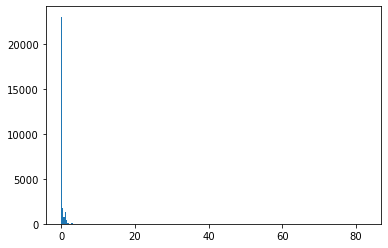

In [135]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class'] == 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=300)

### 2) 이상 데이터의 재구성 오류 분포 확인

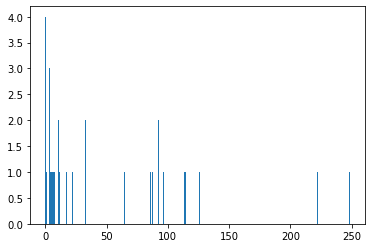

In [136]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=300)

### 3) 정밀도 vs 재현율

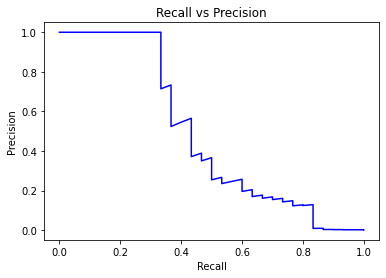

In [137]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### 4) 임계값에 따른 정밀도

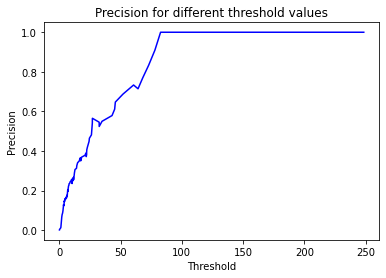

In [138]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

### 5) 임계값에 따른 재현율

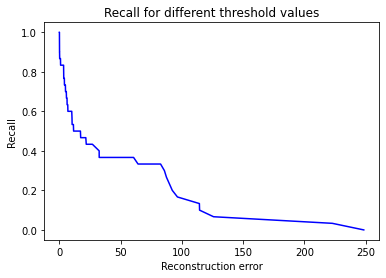

In [139]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

## 11. 최적의 임계값 찾기

In [186]:
max_score = 0
best_th = 0

for i in tqdm(th):
    pred_class = np.where(mse > i, 1, 0)
    score = f1_score(val_Y, pred_class, average='macro')
    
    if max_score < score:
        max_score = score
        best_th = i

  0%|          | 0/28451 [00:00<?, ?it/s]

In [187]:
print(f"Best f1-score : {max_score}")
print(f"Best threshold : {best_th}")

Best f1-score : 0.7597890072792488
Best threshold : 30.002564009499945


- 더 해볼 것 
    - 정상 데이터로만 학습시키는 모델의 accuracy 및 loss 값 개선할 것